# Visible Human MRI Dataset - Exploratory Data Analysis

This notebook performs EDA on the Visible Human MRI dataset containing:
- **PD**: Proton Density weighted (76 slices, 256×256)
- **T1**: T1-weighted (76 slices, 256×256)
- **T2**: T2-weighted (76 slices, 256×256)
- **T2_512**: T2-weighted high resolution (228 slices, 512×512)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load all volumes
data_path = Path("visible_human_mri")
modalities = ["PD", "T1", "T2", "T2_512"]

volumes = {}
for mod in modalities:
    volumes[mod] = np.load(data_path / f"{mod}.npy")
    print(f"{mod}: shape={volumes[mod].shape}, dtype={volumes[mod].dtype}")

PD: shape=(76, 256, 256), dtype=uint16
T1: shape=(76, 256, 256), dtype=uint16
T2: shape=(76, 256, 256), dtype=uint16
T2_512: shape=(228, 512, 512), dtype=uint16


## 1. Statistical Summary

In [4]:
import pandas as pd

# Compute statistics for each volume
stats = []
for mod, vol in volumes.items():
    stats.append({
        "Modality": mod,
        "Shape": str(vol.shape),
        "Min": vol.min(),
        "Max": vol.max(),
        "Mean": f"{vol.mean():.2f}",
        "Std": f"{vol.std():.2f}",
        "Median": np.median(vol),
        "Non-zero %": f"{(vol > 0).sum() / vol.size * 100:.1f}%",
        "Memory (MB)": f"{vol.nbytes / 1024 / 1024:.2f}"
    })

stats_df = pd.DataFrame(stats)
stats_df

Modality            Shape  Min   Max    Mean     Std  Median Non-zero %  \
0       PD   (76, 256, 256)    0  1486  200.29  292.60    11.0      79.3%   
1       T1   (76, 256, 256)    0  1633  141.91  214.39    10.0      79.3%   
2       T2   (76, 256, 256)    0  1094   80.86  123.66    10.0      79.2%   
3   T2_512  (228, 512, 512)    0  1659   92.71  141.76    16.0      92.5%   

  Memory (MB)  
0        9.50  
1        9.50  
2        9.50  
3      114.00

## 2. Sample Slices Visualization

Visualize axial slices from each modality at different depths.

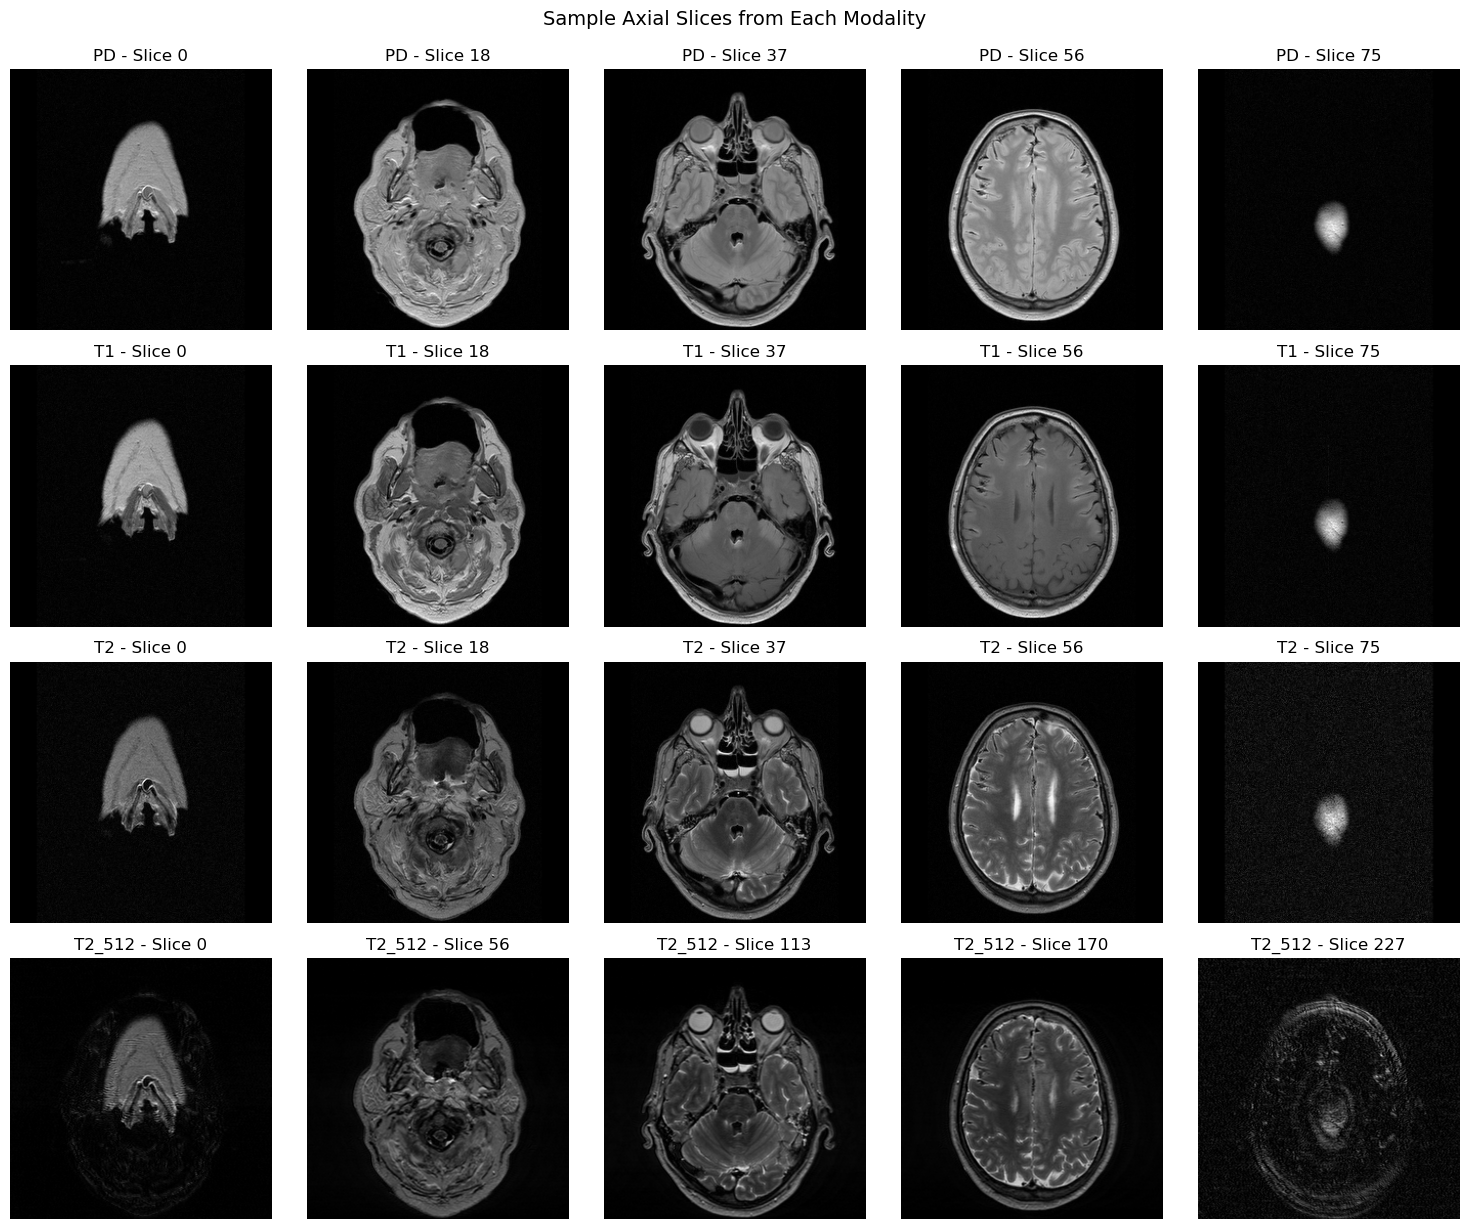

In [6]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for row, (mod, vol) in enumerate(volumes.items()):
    n_slices = vol.shape[0]
    slice_indices = np.linspace(0, n_slices - 1, 5, dtype=int)
    
    for col, idx in enumerate(slice_indices):
        ax = axes[row, col]
        ax.imshow(vol[idx], cmap='gray')
        ax.set_title(f"{mod} - Slice {idx}")
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Sample Axial Slices from Each Modality", y=1.02, fontsize=14)
plt.show()

## 3. Intensity Histograms

Distribution of pixel intensities for each modality.

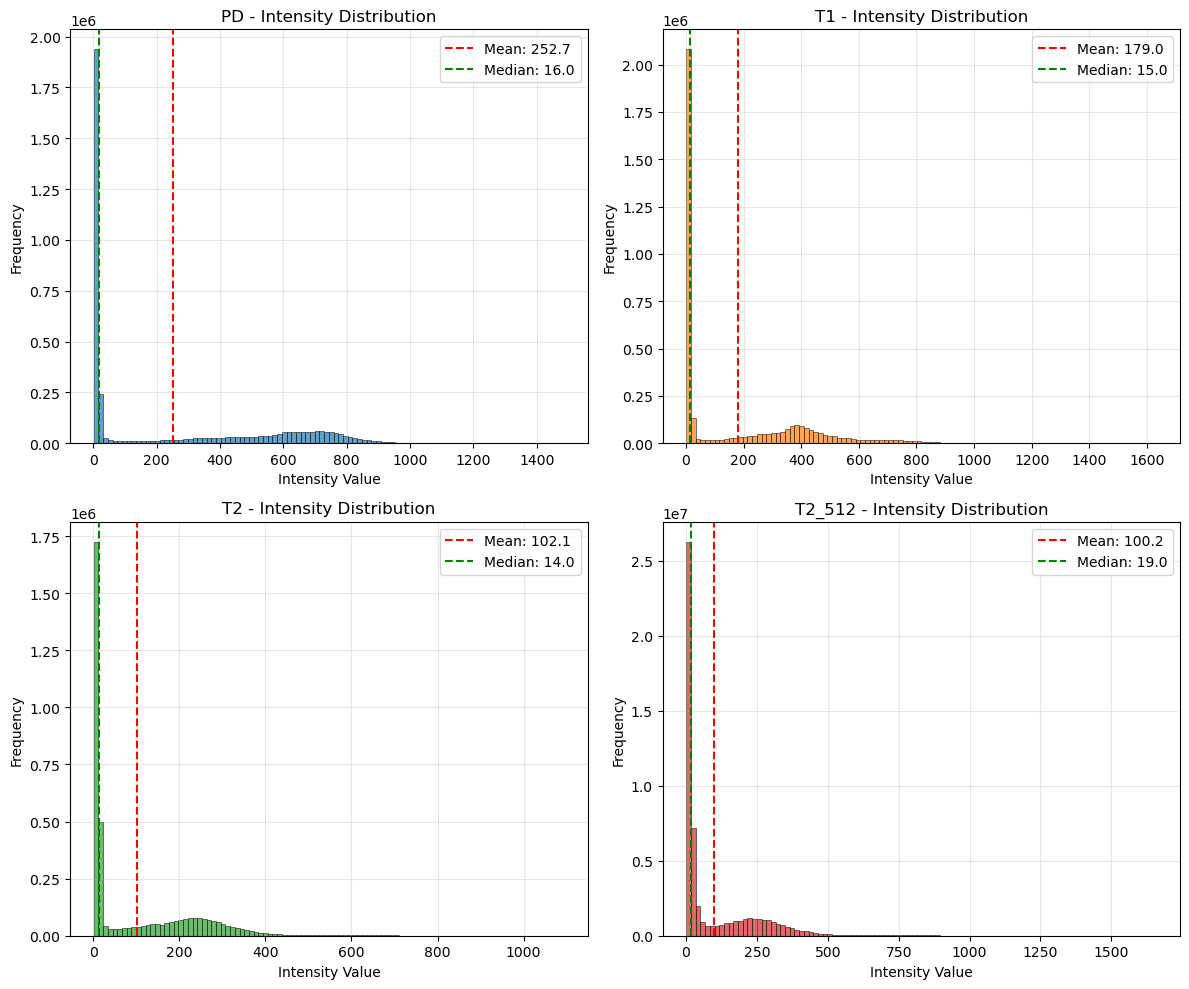

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (mod, vol) in enumerate(volumes.items()):
    ax = axes[idx]
    
    # Flatten and remove zeros for better visualization
    data = vol.flatten()
    data_nonzero = data[data > 0]
    
    ax.hist(data_nonzero, bins=100, alpha=0.7, color=colors[idx], edgecolor='black', linewidth=0.5)
    ax.set_title(f"{mod} - Intensity Distribution", fontsize=12)
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Frequency")
    ax.axvline(np.mean(data_nonzero), color='red', linestyle='--', label=f'Mean: {np.mean(data_nonzero):.1f}')
    ax.axvline(np.median(data_nonzero), color='green', linestyle='--', label=f'Median: {np.median(data_nonzero):.1f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Multi-View Visualization (Orthogonal Views)

Show axial, sagittal, and coronal views for each modality.

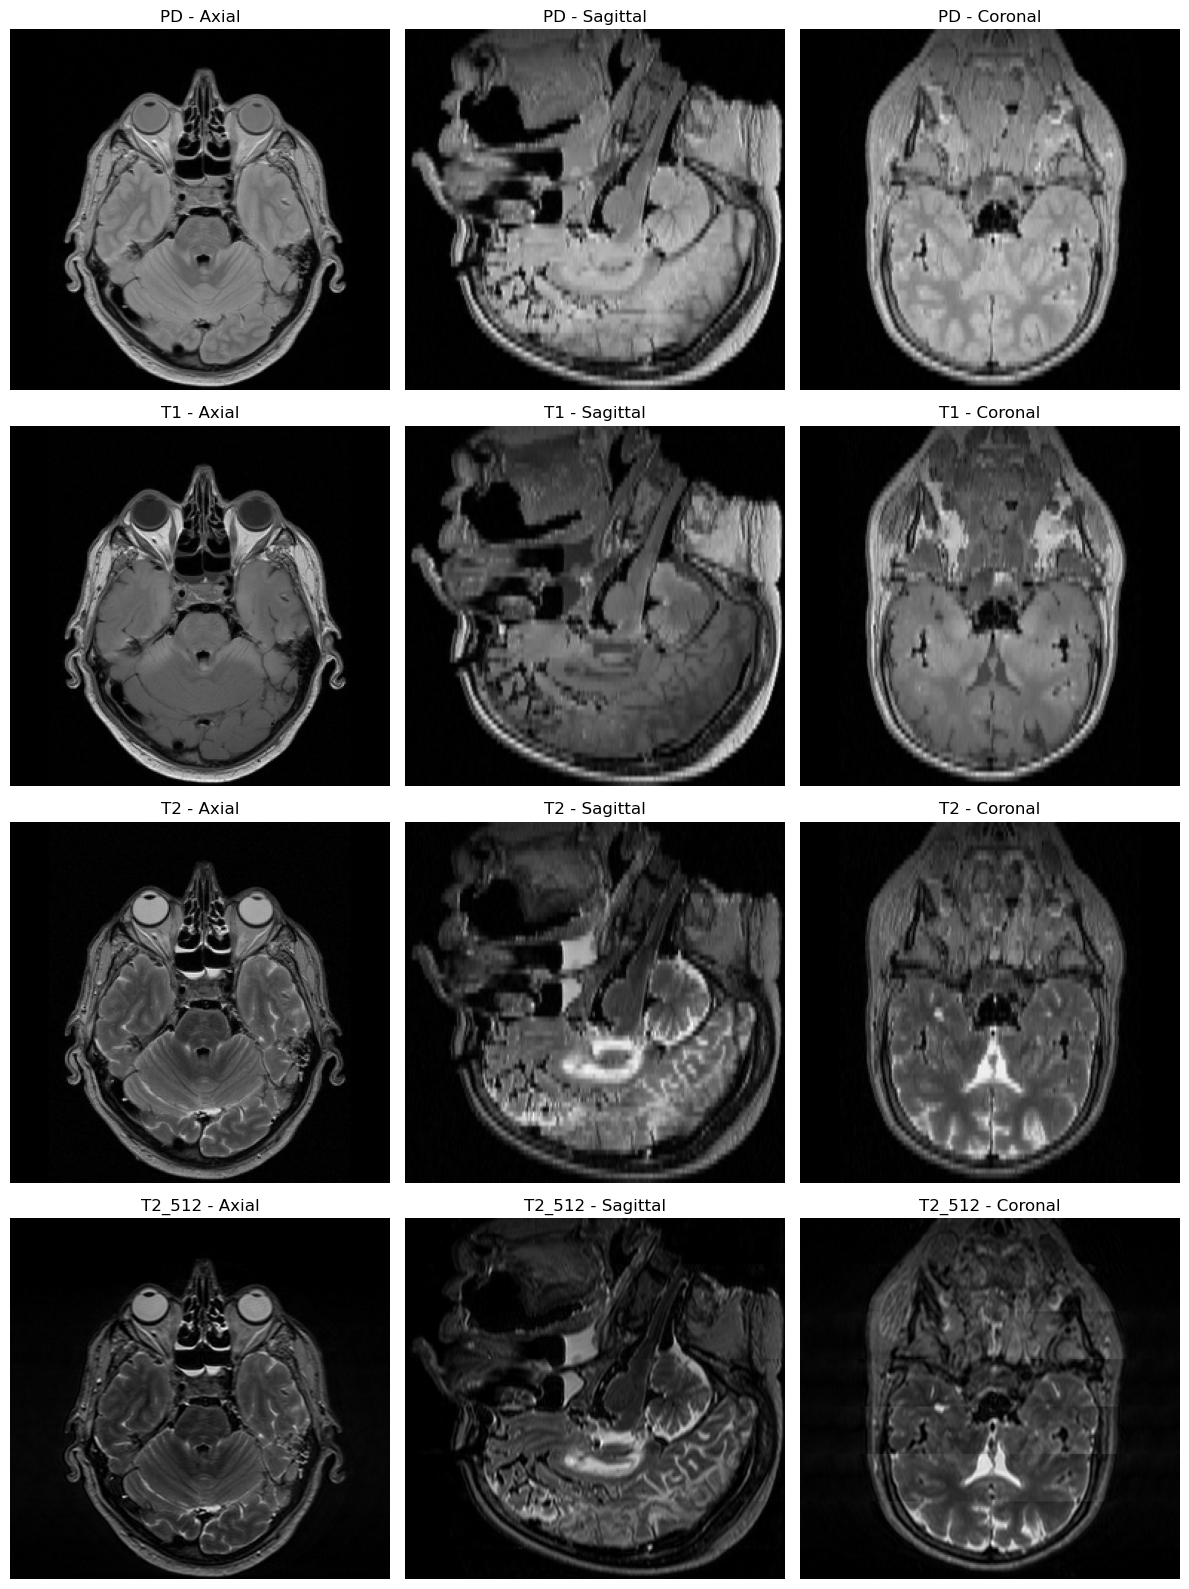

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

view_names = ['Axial', 'Sagittal', 'Coronal']

for row, (mod, vol) in enumerate(volumes.items()):
    d, h, w = vol.shape
    
    # Middle slices for each view
    axial = vol[d // 2]
    sagittal = vol[:, :, w // 2]
    coronal = vol[:, h // 2, :]
    
    views = [axial, sagittal, coronal]
    
    for col, (view, name) in enumerate(zip(views, view_names)):
        ax = axes[row, col]
        ax.imshow(view, cmap='gray', aspect='auto')
        ax.set_title(f"{mod} - {name}")
        ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Modality Comparison (Same Slice)

Compare the same anatomical location across PD, T1, and T2 modalities (256×256 resolution).

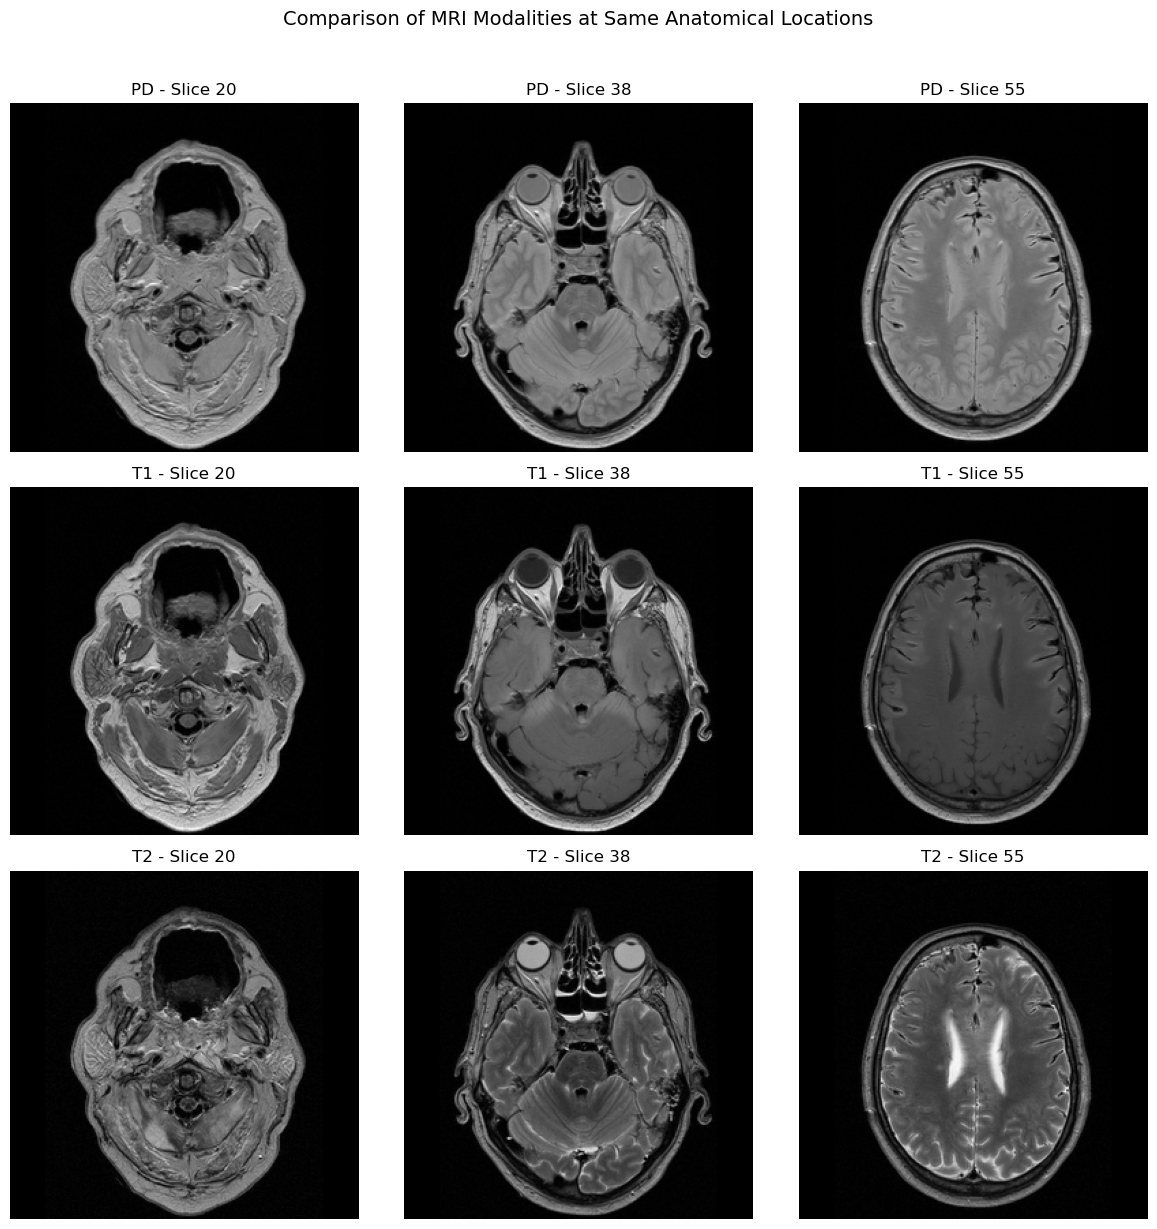

In [10]:
# Compare same slice across 256x256 modalities
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

slice_indices = [20, 38, 55]  # Different brain regions
mods_256 = ["PD", "T1", "T2"]

for col, slice_idx in enumerate(slice_indices):
    for row, mod in enumerate(mods_256):
        ax = axes[row, col]
        ax.imshow(volumes[mod][slice_idx], cmap='gray')
        ax.set_title(f"{mod} - Slice {slice_idx}")
        ax.axis('off')

plt.suptitle("Comparison of MRI Modalities at Same Anatomical Locations", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Intensity Profiles

Analyze intensity profiles along horizontal and vertical lines through the brain.

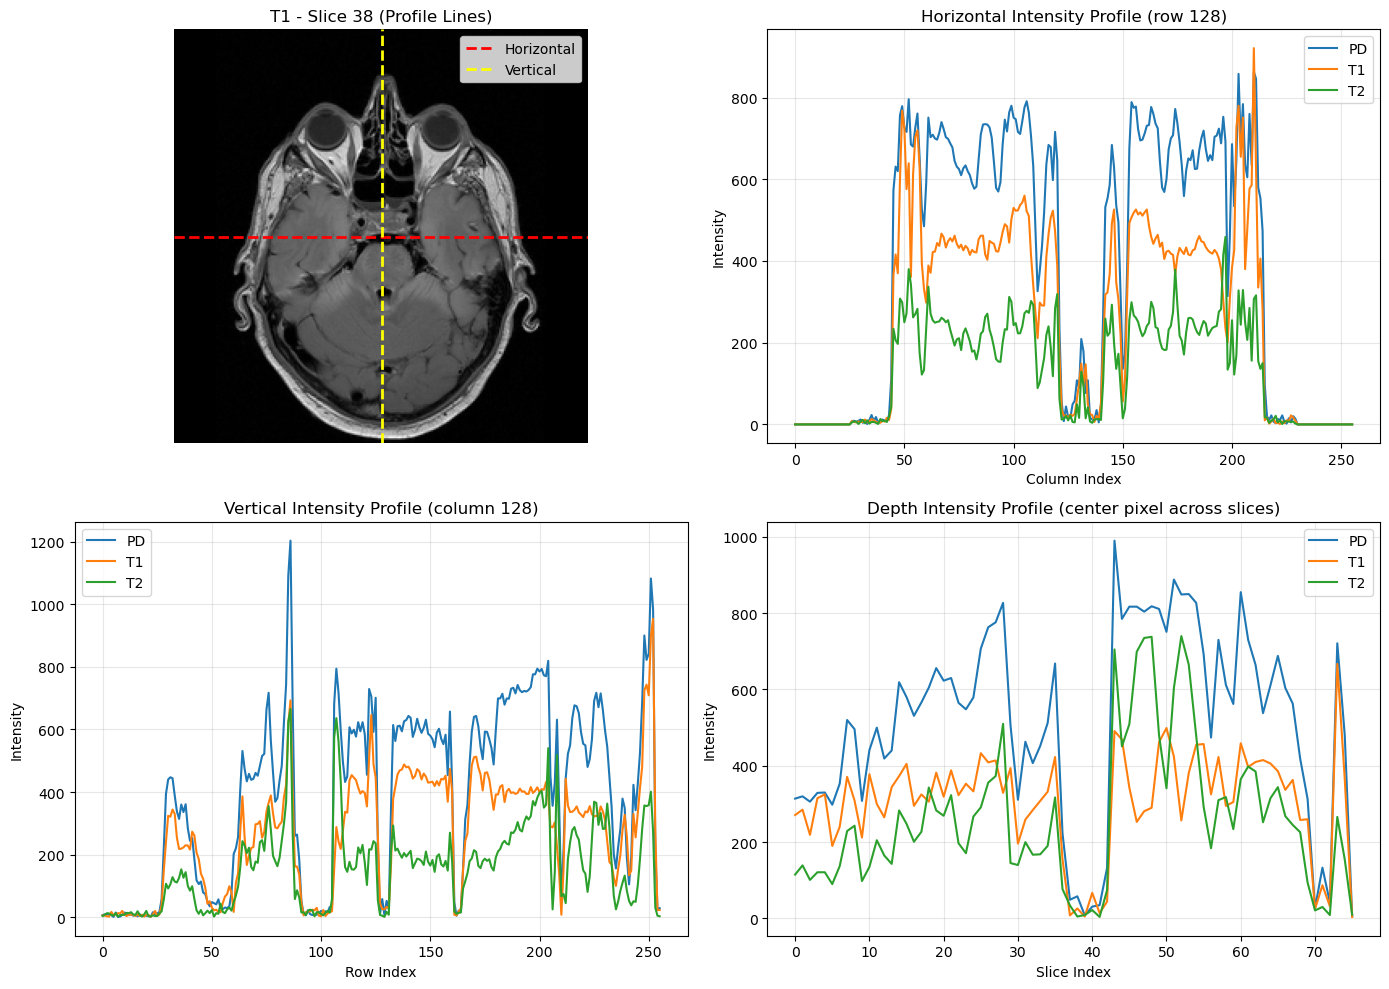

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

slice_idx = 38  # Mid-brain slice
mods_256 = ["PD", "T1", "T2"]
colors = {'PD': '#1f77b4', 'T1': '#ff7f0e', 'T2': '#2ca02c'}

# Show the reference slice
ax = axes[0, 0]
ref_img = volumes["T1"][slice_idx]
ax.imshow(ref_img, cmap='gray')
ax.axhline(y=128, color='red', linestyle='--', linewidth=2, label='Horizontal')
ax.axvline(x=128, color='yellow', linestyle='--', linewidth=2, label='Vertical')
ax.set_title(f"T1 - Slice {slice_idx} (Profile Lines)")
ax.legend(loc='upper right')
ax.axis('off')

# Horizontal profile
ax = axes[0, 1]
for mod in mods_256:
    profile = volumes[mod][slice_idx, 128, :]
    ax.plot(profile, label=mod, color=colors[mod], linewidth=1.5)
ax.set_title("Horizontal Intensity Profile (row 128)")
ax.set_xlabel("Column Index")
ax.set_ylabel("Intensity")
ax.legend()
ax.grid(True, alpha=0.3)

# Vertical profile
ax = axes[1, 0]
for mod in mods_256:
    profile = volumes[mod][slice_idx, :, 128]
    ax.plot(profile, label=mod, color=colors[mod], linewidth=1.5)
ax.set_title("Vertical Intensity Profile (column 128)")
ax.set_xlabel("Row Index")
ax.set_ylabel("Intensity")
ax.legend()
ax.grid(True, alpha=0.3)

# Depth profile (across slices)
ax = axes[1, 1]
for mod in mods_256:
    profile = volumes[mod][:, 128, 128]
    ax.plot(profile, label=mod, color=colors[mod], linewidth=1.5)
ax.set_title("Depth Intensity Profile (center pixel across slices)")
ax.set_xlabel("Slice Index")
ax.set_ylabel("Intensity")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Correlation Analysis

Analyze correlation between different modalities.

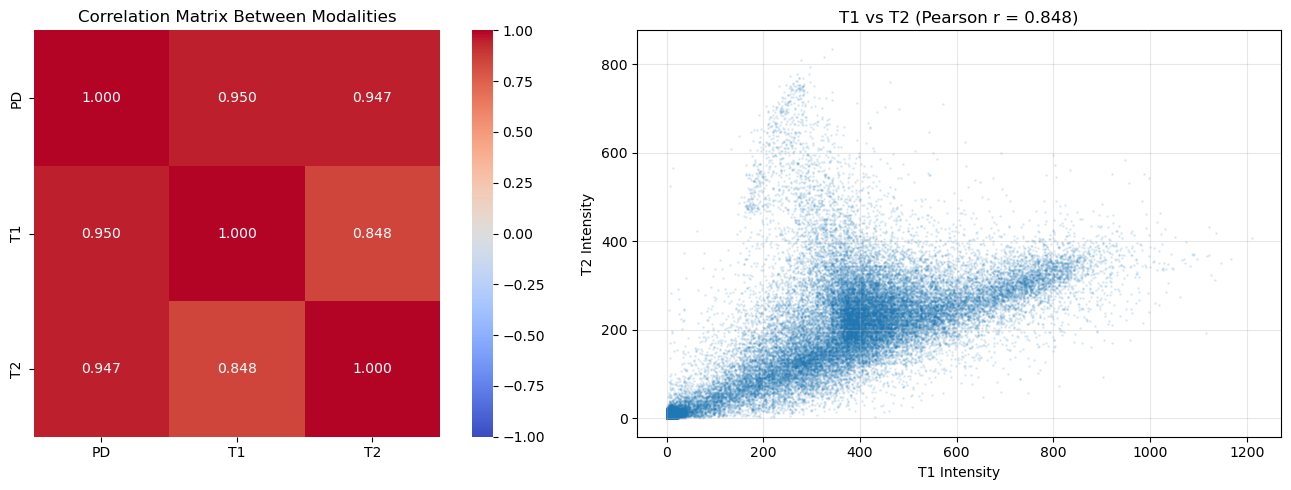


Correlation Matrix:
        PD      T1      T2
PD  1.0000  0.9504  0.9467
T1  0.9504  1.0000  0.8477
T2  0.9467  0.8477  1.0000


In [12]:
import seaborn as sns

# Compute correlation matrix for 256x256 modalities
mods_256 = ["PD", "T1", "T2"]
data_flat = {mod: volumes[mod].flatten() for mod in mods_256}

# Subsample for correlation computation (to save memory)
n_samples = 100000
np.random.seed(42)
indices = np.random.choice(len(data_flat["PD"]), n_samples, replace=False)

corr_data = {mod: data_flat[mod][indices] for mod in mods_256}
corr_df = pd.DataFrame(corr_data)
corr_matrix = corr_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax = axes[0]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, fmt='.3f', ax=ax)
ax.set_title("Correlation Matrix Between Modalities")

# Scatter plot matrix (pairwise)
ax = axes[1]
ax.scatter(corr_data["T1"], corr_data["T2"], alpha=0.1, s=1)
ax.set_xlabel("T1 Intensity")
ax.set_ylabel("T2 Intensity")
ax.set_title(f"T1 vs T2 (Pearson r = {corr_matrix.loc['T1', 'T2']:.3f})")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(corr_matrix.round(4))

## Direct Volume Rendering (DVR)

Using ray-marching to render 3D volumes with transfer functions for opacity and color mapping.

PD: Original (76, 256, 256) -> Isotropic (256, 256, 256)
T1: Original (76, 256, 256) -> Isotropic (256, 256, 256)
T2: Original (76, 256, 256) -> Isotropic (256, 256, 256)


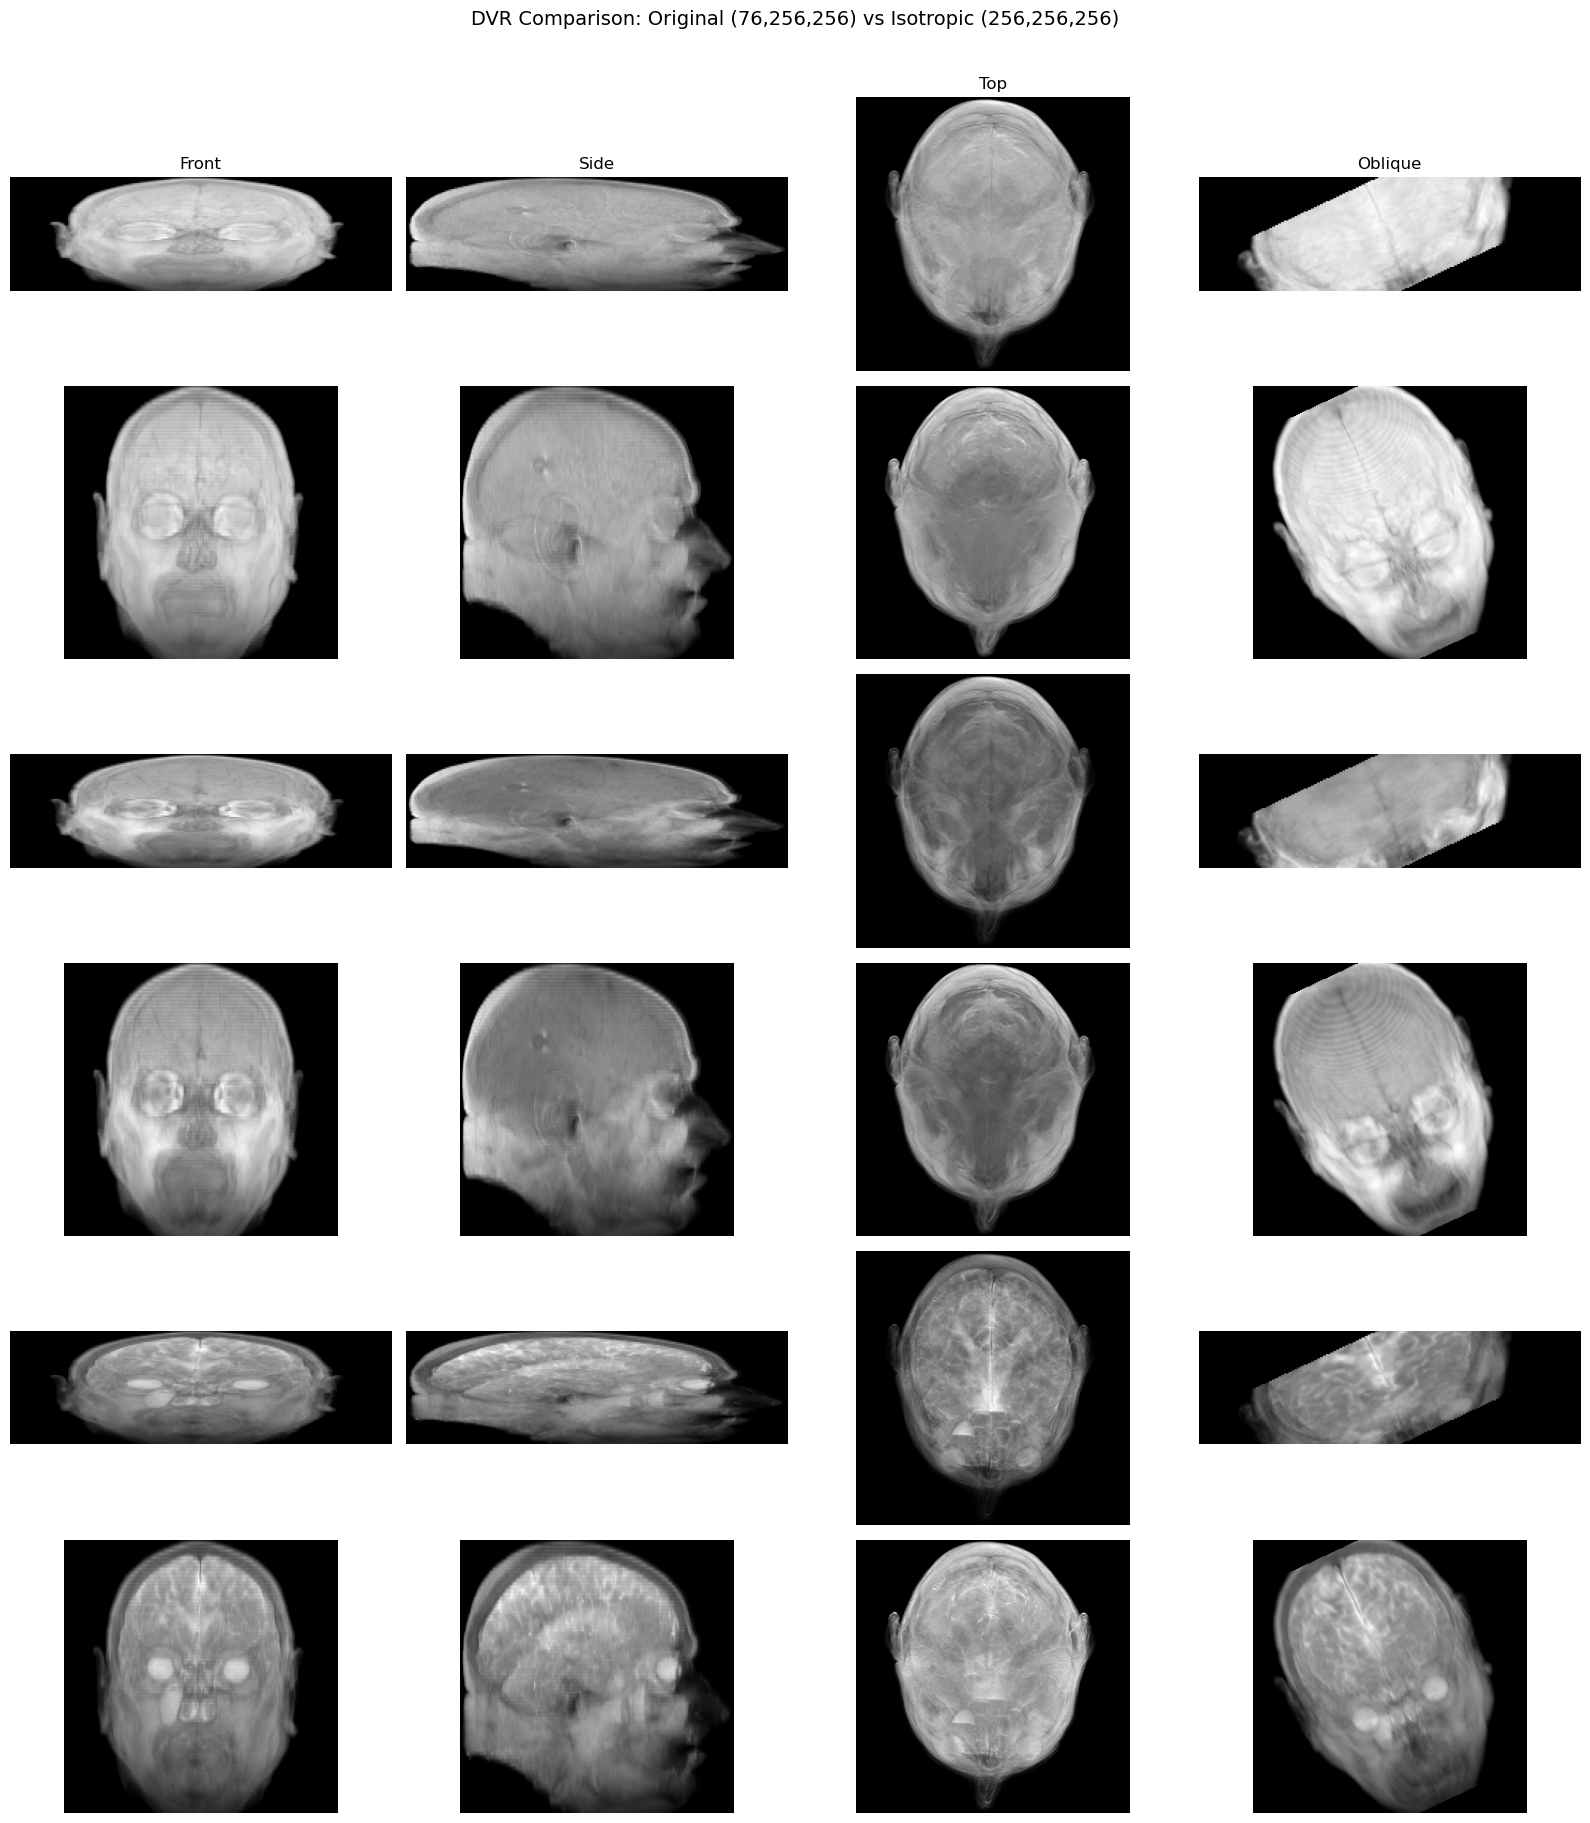

In [20]:
from scipy.ndimage import zoom, rotate

def make_isotropic(volume):
    """Resample volume to isotropic voxels (same size in all dimensions)."""
    d, h, w = volume.shape
    scale_factor = h / d
    return zoom(volume, (scale_factor, 1, 1), order=1)

def dvr_render(volume, view='front', threshold=0.1):
    """Direct Volume Rendering using ray-marching with front-to-back compositing."""
    vol = volume.astype(np.float32)
    vol = (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)
    
    if view == 'front':
        vol_view = np.transpose(vol, (1, 0, 2))
    elif view == 'side':
        vol_view = np.transpose(vol, (2, 0, 1))
    elif view == 'top':
        vol_view = vol
    elif view == 'oblique':
        vol_view = np.transpose(vol, (1, 0, 2))
        vol_view = rotate(vol_view, 30, axes=(0, 1), reshape=False, order=1)
        vol_view = rotate(vol_view, 25, axes=(1, 2), reshape=False, order=1)
    else:
        vol_view = vol
    
    output_h, output_w = vol_view.shape[1], vol_view.shape[2]
    image = np.zeros((output_h, output_w), dtype=np.float32)
    opacity = np.zeros((output_h, output_w), dtype=np.float32)
    
    for z_idx in range(vol_view.shape[0]):
        slice_data = vol_view[z_idx]
        slice_opacity = np.where(slice_data > threshold, slice_data * 0.1, 0)
        remaining_opacity = 1.0 - opacity
        contribution = slice_data * slice_opacity * remaining_opacity
        image += contribution
        opacity += slice_opacity * remaining_opacity
        if np.all(opacity > 0.99):
            break
    
    return np.clip(image, 0, 1)

# Compare Original vs Isotropic DVR for all modalities
mods_256 = ["PD", "T1", "T2"]
views = ['front', 'side', 'top', 'oblique']
view_names = ["Front", "Side", "Top", "Oblique"]

fig, axes = plt.subplots(len(mods_256) * 2, 4, figsize=(16, 18))

for mod_idx, mod in enumerate(mods_256):
    vol_orig = volumes[mod]
    vol_iso = make_isotropic(vol_orig)
    
    row_orig = mod_idx * 2
    row_iso = mod_idx * 2 + 1
    
    print(f"{mod}: Original {vol_orig.shape} -> Isotropic {vol_iso.shape}")
    
    for col, (view, name) in enumerate(zip(views, view_names)):
        # Original
        rendered_orig = np.rot90(dvr_render(vol_orig, view=view, threshold=0.05), 2)
        axes[row_orig, col].imshow(rendered_orig, cmap='gray')
        if col == 0:
            axes[row_orig, col].set_ylabel(f"{mod}\nOriginal", fontsize=11)
        if mod_idx == 0:
            axes[row_orig, col].set_title(name, fontsize=12)
        axes[row_orig, col].axis('off')
        
        # Isotropic
        rendered_iso = np.rot90(dvr_render(vol_iso, view=view, threshold=0.05), 2)
        axes[row_iso, col].imshow(rendered_iso, cmap='gray')
        if col == 0:
            axes[row_iso, col].set_ylabel(f"{mod}\nIsotropic", fontsize=11)
        axes[row_iso, col].axis('off')

plt.suptitle("DVR Comparison: Original (76,256,256) vs Isotropic (256,256,256)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 8. Data Preprocessing

Prepare the dataset for deep learning:
- Normalize intensities to [0, 1]
- Create paired slices (input → target) for modality synthesis
- Split into train/validation/test sets
- Save preprocessed data

In [22]:
import os
from sklearn.model_selection import train_test_split

def normalize_volume(vol, method='minmax'):
    """Normalize volume intensities."""
    vol = vol.astype(np.float32)
    if method == 'minmax':
        # Min-max normalization to [0, 1]
        v_min, v_max = vol.min(), vol.max()
        return (vol - v_min) / (v_max - v_min + 1e-8)
    elif method == 'zscore':
        # Z-score normalization (mean=0, std=1)
        return (vol - vol.mean()) / (vol.std() + 1e-8)
    elif method == 'percentile':
        # Percentile-based normalization (robust to outliers)
        p1, p99 = np.percentile(vol, [1, 99])
        vol_clipped = np.clip(vol, p1, p99)
        return (vol_clipped - p1) / (p99 - p1 + 1e-8)
    return vol

# Preprocess 256x256 modalities (PD, T1, T2)
print("=" * 60)
print("PREPROCESSING DATASET")
print("=" * 60)

# Use original resolution (76, 256, 256) - recommended for 2D slice-based training
mods_256 = ["PD", "T1", "T2"]

# Normalize each volume
normalized = {}
for mod in mods_256:
    normalized[mod] = normalize_volume(volumes[mod], method='minmax')
    print(f"{mod}: range [{normalized[mod].min():.3f}, {normalized[mod].max():.3f}]")

# Create paired dataset (slice-by-slice for all modalities)
n_slices = normalized["T1"].shape[0]  # 76 slices
slice_indices = np.arange(n_slices)

# Split: 70% train, 15% val, 15% test (by slice index)
train_idx, temp_idx = train_test_split(slice_indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

print(f"\nSplit: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")
print(f"Train slices: {sorted(train_idx)}")
print(f"Val slices: {sorted(val_idx)}")
print(f"Test slices: {sorted(test_idx)}")

# Create output directory
output_dir = Path("dataset/preprocessed")
output_dir.mkdir(parents=True, exist_ok=True)

# Save preprocessed volumes
preprocessed = {
    'PD': normalized['PD'],
    'T1': normalized['T1'],
    'T2': normalized['T2'],
    'train_idx': train_idx,
    'val_idx': val_idx,
    'test_idx': test_idx
}

np.savez_compressed(
    output_dir / "mri_preprocessed.npz",
    **preprocessed
)
print(f"\n✓ Saved preprocessed data to {output_dir / 'mri_preprocessed.npz'}")

# Also save as individual numpy files for easier loading
for mod in mods_256:
    np.save(output_dir / f"{mod}_normalized.npy", normalized[mod])
np.save(output_dir / "train_indices.npy", train_idx)
np.save(output_dir / "val_indices.npy", val_idx)
np.save(output_dir / "test_indices.npy", test_idx)

print(f"✓ Saved individual files to {output_dir}/")

# Summary
print("\n" + "=" * 60)
print("PREPROCESSED DATASET SUMMARY")
print("=" * 60)
summary = {
    "Modalities": mods_256,
    "Volume shape": str(normalized['T1'].shape),
    "Data type": str(normalized['T1'].dtype),
    "Normalization": "Min-Max [0, 1]",
    "Train slices": len(train_idx),
    "Val slices": len(val_idx),
    "Test slices": len(test_idx),
    "Total slices": n_slices
}
for k, v in summary.items():
    print(f"{k:20}: {v}")

PREPROCESSING DATASET
PD: range [0.000, 1.000]
T1: range [0.000, 1.000]
T2: range [0.000, 1.000]

Split: Train=53, Val=11, Test=12
Train slices: [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(19), np.int64(20), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(29), np.int64(31), np.int64(32), np.int64(36), np.int64(37), np.int64(38), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(46), np.int64(48), np.int64(49), np.int64(51), np.int64(52), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(66), np.int64(68), np.int64(69), np.int64(71), np.int64(72), np.int64(73), np.int64(74), np.int64(75)]
Val slices: [np.int64(0), np.int64(9), np.int64(22), np.int64(34), np.int64(39), np.int64(40), np.int64(45), np.int64(